In [48]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.5em;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
}
</style>
""")

# Dota2 contest

По первым 5 минутам игры предсказать, какая из команд победит: Radiant или Dire?

https://inclass.kaggle.com/c/dota-2-win-probability-prediction

## Предметная область

Dota 2 — многопользовательская компьютерная игра жанра MOBA. Игроки играют между собой матчи. В каждом матче участвует две команды, 5 человек в каждой. Одна команда играет за светлую сторону (The Radiant), другая — за тёмную (The Dire). Цель каждой команды — уничтожить главное здание базы противника (трон).

![](images/dota.jpeg)

### Как проходит матч

#### 1. Выбор героев

Всего в игре чуть более 100 различных героев (персонажей). Герои различаются между собой своими характеристиками и способностями. От комбинации выбранных героев во многом зависит успех команды.

#### 2. Основная игра

Игроки могут получать золото и опыт за убийство чужих героев или прочих юнитов. Накопленный опыт влияет на уровень героя, который в свою очередь позволяет улучшать способности. За накопленное золото игроки покупают предметы, которые улучшают характеристики героев или дают им новые способности.

После смерти герой отправляется в "таверну" и возрождается только по прошествии некоторого времени, таким образом команда на некоторое время теряет игрока, однако игрок может досрочно выкупить героя из таверны за определенную сумму золота.

#### 3. Конец игры

Игра заканчивается, когда одна из команд разрушет определенное число "башен" противника и уничтожает трон.

## Признаки

- `match_id`: идентификатор матча в наборе данных
- `start_time`: время начала матча (unixtime)
- `lobby_type`: тип комнаты, в которой собираются игроки (расшифровка в `dictionaries/lobbies.csv`)

- Наборы признаков для каждого игрока (игроки команды Radiant — префикс `rN`, Dire — `dN`):
    - `rN_hero`: герой игрока (расшифровка в dictionaries/heroes.csv)
    - `rN_level`: максимальный достигнутый уровень героя (за первые 5 игровых минут)
    - `rN_xp`: максимальный полученный опыт
    - `rN_gold`: достигнутая ценность героя
    - `rN_lh`: число убитых юнитов
    - `rN_kills`: число убитых игроков
    - `rN_deaths`: число смертей героя
    - `rN_items`: число купленных предметов
    
- Признаки события "первая кровь" (first blood). Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение
    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию
    
- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_tpscroll_count`: число предметов "tpscroll" за первые 5 минут
    - `radiant_boots_count`: число предметов "boots"
    - `radiant_ward_observer_count`: число предметов "ward_observer"
    - `radiant_ward_sentry_count`: число предметов "ward_sentry"
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля
    
- Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
    - `duration`: длительность
    - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
    - Состояние башен и барраков к концу матча (см. описание полей набора данных)
        - `tower_status_radiant`
        - `tower_status_dire`
        - `barracks_status_radiant`
        - `barracks_status_dire`

In [21]:
# магическая функция, чтобы графики рисовались в ноутбуке, а не в отдельном окне
%matplotlib inline
import matplotlib # графики
import numpy as np # библиотека для вычислений, там есть все полезные математические функции
import matplotlib.pyplot as plt # графики
import pandas as pd # утилиты для работы с данными, умеет csv, sql и так далее...
pd.set_option('display.max_columns', 500)
import seaborn as sns # красивые графики
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12 # увеличиваем размер картинок

import datetime

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, KFold

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, Lasso, RidgeClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures
from scipy import sparse

In [2]:
# df - data frame.
# Загружаем тренировочную выборку
df = pd.read_csv("data/features.csv.zip", compression='zip', index_col='match_id')
df.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_hero,d1_level,d1_xp,d1_gold,d1_lh,d1_kills,d1_deaths,d1_items,d2_hero,d2_level,d2_xp,d2_gold,d2_lh,d2_kills,d2_deaths,d2_items,d3_hero,d3_level,d3_xp,d3_gold,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,0,1,11,4,3,1058,996,12,0,0,6,42,4,1085,986,12,0,0,4,21,5,2052,1536,23,0,0,6,37,3,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,NaN,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,0,0,5,39,5,1960,1384,16,0,0,8,88,3,640,566,1,0,1,5,79,3,720,1350,2,2,0,12,7,2,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,NaN,173.0,-80.0,NaN,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,0,0,9,22,5,2305,2028,19,1,1,10,66,3,1024,959,19,0,1,10,86,3,755,620,3,0,0,8,29,4,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,NaN,63.0,-82.0,NaN,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,0,0,6,96,5,1878,1174,17,0,0,6,48,3,732,1468,22,0,0,10,15,4,1681,1051,11,0,0,7,102,2,674,537,1,0,0,7,20,2,510,499,0,0,0,7,NaN,NaN,NaN,NaN,208.0,-75.0,NaN,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,0,0,8,26,3,704,586,1,0,2,9,69,3,1169,1665,20,1,0,7,22,3,1055,638,1,0,0,9,25,5,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,NaN,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,2449,0,4,1974,3,63


# Исследуем данные

Для начала посмотрим информацию о датафреме и базовые характеристики признаков

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97230 entries, 0 to 114406
Columns: 108 entries, start_time to barracks_status_dire
dtypes: float64(12), int64(96)
memory usage: 80.9 MB


In [11]:
df.describe()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_hero,d1_level,d1_xp,d1_gold,d1_lh,d1_kills,d1_deaths,d1_items,d2_hero,d2_level,d2_xp,d2_gold,d2_lh,d2_kills,d2_deaths,d2_items,d3_hero,d3_level,d3_xp,d3_gold,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
count,9.723000e+04,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,77677.000000,77677.000000,77677.000000,53243.000000,81539.000000,96538.000000,69751.000000,97230.000000,97230.000000,97230.000000,97230.000000,95394.000000,81087.000000,96554.000000,71132.000000,97230.000000,97230.000000,97230.000000,97230.000000,95404.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000
mean,1.444232e+09,2.630999,51.517104,3.442672,1233.405801,1147.899702,11.231996,0.357009,0.362285,8.271315,52.183452,3.364661,1189.223676,1107.863993,10.471747,0.348709,0.363550,8.275584,52.710491,3.353924,1182.879965,1099.643742,10.333004,0.342723,0.357338,8.273527,52.648092,3.308896,1159.088481,1082.090240,9.981909,0.337746,0.357307,8.275049,52.625630,3.304237,1158.586167,1082.057061,9.995351,0.337262,0.352782,8.288491,51.990106,3.461123,1238.855765,1151.018184,11.253841,0.372262,0.344091,8.296380,52.708547,3.388933,1199.858809,1108.633436,10.460424,0.356238,0.347012,8.310419,52.755137,3.378638,1193.554438,1103.273702,10.386918,0.353533,0.347732,8.305420,52.922421,3.337725,1171.952155,1088.711653,10.035349,0.354952,0.341860,8.319665,53.059694,3.345274,1177.395351,1089.558850,10.053739,0.356063,0.342538,8.323048,97.688029,0.521815,4.593483,4.383224,126.800255,-80.059510,215.987126,2.994775,3.312527,2.431719,0.716250,-6.875747,127.215028,-80.191893,214.870536,2.965566,3.349553,2.448339,0.689119,-6.901922,2332.247886,0.518503,1309.227790,1286.310820,40.599095,41.337036
std,5.515393e+06,2.835761,32.564211,1.111741,566.588895,464.111662,9.041620,0.663889,0.626704,2.497575,32.674077,1.097536,555.363510,458.001007,8.972073,0.654060,0.624236,2.433864,32.560923,1.092126,554.899600,454.727127,8.950871,0.647774,0.618071,2.440139,32.670519,1.092502,550.937530,450.353291

Если внимательно посмотреть, то мы увидем что в данных есть пропуски - NaN значения.

### Что делать с пропусками?
- удалить все строки с пропущенными данными
- заполнить пропуски 0
- заполнить пропуски совсем нехарактерными значениями (большое отрицательное число)
- заполнить пропуск средним, медианой
- заполнить пропуск средним в подгруппе по какому-то другому признаку

Для начала посмотрим какие признаки имеют пропуски

In [3]:
nan_features = [i for i, v in df.count().iteritems() if v < df.shape[0]]
nan_features

['first_blood_time',
 'first_blood_team',
 'first_blood_player1',
 'first_blood_player2',
 'radiant_bottle_time',
 'radiant_courier_time',
 'radiant_flying_courier_time',
 'radiant_first_ward_time',
 'dire_bottle_time',
 'dire_courier_time',
 'dire_flying_courier_time',
 'dire_first_ward_time']

In [20]:
df[nan_features].describe()

,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_first_ward_time
count,77677.000000,77677.000000,77677.000000,53243.000000,81539.000000,96538.000000,69751.000000,95394.000000,81087.000000,96554.000000,71132.000000,95404.000000
mean,97.688029,0.521815,4.593483,4.383224,126.800255,-80.059510,215.987126,-6.875747,127.215028,-80.191893,214.870536,-6.901922
std,82.625879,0.499527,2.886984,2.870915,61.427907,15.814209,34.604997,39.508650,62.442018,15.261950,34.137158,40.701397
min,-78.000000,0.000000,0.000000,0.000000,-37.000000,-90.000000,180.000000,-236.000000,-45.000000,-90.000000,180.000000,-84.000000
25%,15.000000,0.000000,2.000000,2.000000,84.000000,-86.000000,186.000000,-31.000000,83.000000,-86.000000,185.000000,-31.000000
50%,93.000000,1.000000,5.000000,4.000000,131.000000,-83.000000,204.000000,-15.000000,131.000000,-84.000000,203.000000,-16.000000
75%,155.000000,1.000000,7.000000,7.000000,164.000000,-79.000000,241.000000,9.000000,165.000000,-79.000000,238.000000,8.000000
max,300.000000,1.000000,9.000000,9.000000,300.000000,300.000000,300.000000,300.000000,300.000000,296.000000,300.000000,300.000000


Так как у нас есть только первые 5 минут игры, то некоторые характеристки еще не были заполнены. 
Напрмимер, время покупки курьера или first blood.

Интересные детали в данных:
- *_time бывает отрицательным. Это означает, что отсчет времени начала игры немного смещен. Там есть период времени для покупок товарами, распределения внутри команды и так далее. Вполне возмодно отрицательное время не стоит делать положительным. В нем может заключаться некоторый смысл.
- другие признаки категориальные и они распределены от 0 до N. Заполнять нулями на мой взгляд странно. Это может запутать алгоритм.

Предлагаю время заполнить `max + std`

Для категориальных признаков завести специальный номер

In [4]:
def fill_na(df, nan_features):
    times = [f for f in nan_features if f.find('time') != -1]
    categorical = [f for f in nan_features if f.find('time') == -1]
    
    df[times] = df[times].fillna(301.0)
    df[categorical] = df[categorical].fillna(-1)
    return df
    
fill_na(df, nan_features)
[i for i, v in df.count().iteritems() if v < df.shape[0]]

[]

In [5]:
def get_X(df):
   return df.drop(['start_time', 'duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire','barracks_status_radiant', 'barracks_status_dire'], axis=1)

def get_Y(df):
    return df['radiant_win']

In [7]:
X = get_X(df)
y = get_Y(df)

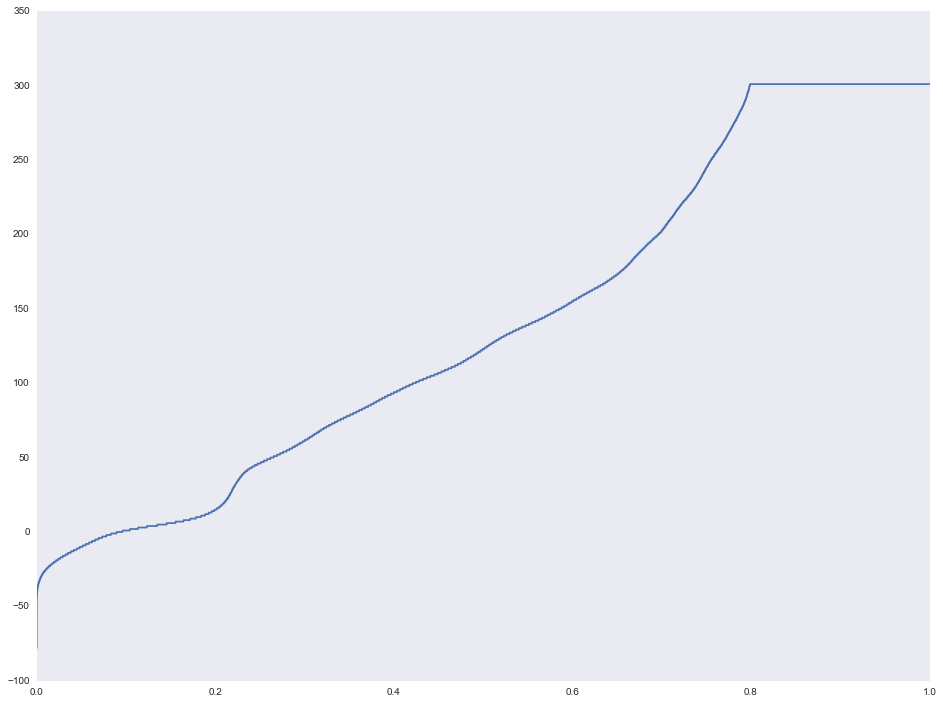

In [74]:
support = np.linspace(0, 1, df.shape[0])
plt.plot(support, df['first_blood_time'].sort_values())

# Глупое предсказание

![](images/ololosh.jpg)

В качестве базового предсказателя часто берут какой-то константный предсказатель, чтобы понять, что хуже него ни в коем случае быть нельзя.

В нашем случае выборка сбалансированная, поэтому если мы будем просто предсказывать что победит вторая команда, то мы получим точность в 50%.

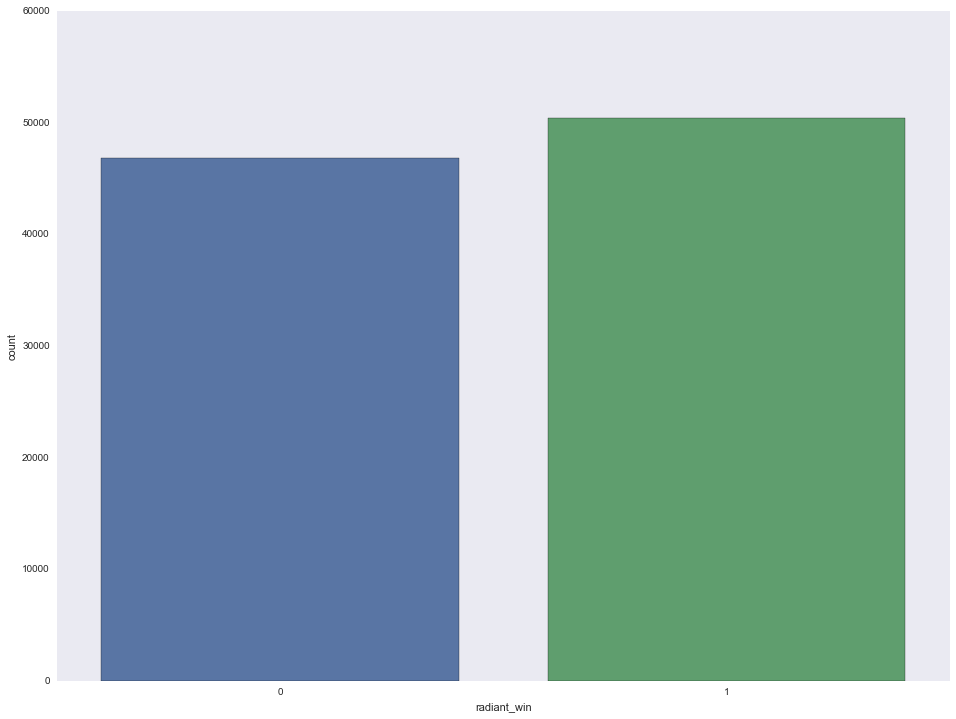

In [69]:
# почти сбалансированные данные, отлично
sns.countplot(data=df, x='radiant_win')

In [20]:
clf = DummyClassifier(random_state=42)
scores = cross_val_score(clf, X, y, scoring='roc_auc')
print("ROC_AUC: mean={}, std={}".format(scores.mean(), 2*scores.std()))

ROC_AUC: mean=0.5003919299939009, std=0.005770428948303072


# Решаем в Лоб

Иногда полезно попробовать парочку моделей на чистых признаках без предподготовки. Это хорошая стартовая линия, по ней мы сможем ориентироваться, улучшаем ли мы модель или нет.

Можно поробовать: 
- Градиентный бустинг на деревьях
- Cлучайный лес
- K ближайших соседей
- Линеный классификатор
- Машину опорных векторов

Для оценки качества предсказания будем пользоваться кросс-валидацией. Это когда данные разбивают случайным образом на наборы, тренируются на них и предсказывают, а потом получается среднее значение качества и погрешность.

![](images/xgboost.jpg)

# Метрика качества

В задачах бинарной классификации можно использовать метрики accuracy, roc_auc, f1, log_loss, precision, recall.

## Ошибки 1, 2 рода

- true-positive, TP — пациент болен раком, диагноз положительный
- false-positive, FP — пациент здоров, диагноз положительный
- true-negative, TN — пациент здоров, диагноз отрицательный
- false-negative, FN — пациент болен раком, диагноз отрицательный

![](images/errors_matrix.png)

- Precision - точность - способность алгоритма «видеть» больных
- Recall - специфичность - способность алгоритма не принимать здоровых за больных

$$Precision = \frac{TP}{TP+FP}$$

$$Recall = \frac{TP}{TP+FN}$$

## F1

1- хорошо, 0 - плохо
$$F1 = 2 * \frac{precision * recall}{precision + recall} = \frac{2TP}{2TP + FP + FN}$$

![](images/f1.png)


## Площадь под ROC кривой

$$FPR = \frac{FP}{FP+TN}$$

$$TPR=\frac{TP}{TP+FN}$$

![](images/roc_auc.png)

In [8]:
def examine(clf, X, y, scoring='roc_auc'):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    start_time = datetime.datetime.now()
    scores = cross_val_score(clf, X, y, scoring=scoring, cv=cv, n_jobs=4)
    end_time = datetime.datetime.now()
    result = (clf.__class__.__name__, scoring, scores.mean(), scores.std()*2, end_time-start_time)
    return result

def print_report(result):
    print('{0}. {1} {2:.5f} +-{3:.5f}. Time to fit: {4}'.format(result[0], result[1], result[2], result[3], result[4]))

In [87]:
classifiers = [
    DummyClassifier(random_state=42), 
    Lasso(random_state=42), 
    RidgeClassifier(random_state=42),
    SGDClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(n_estimators=30, random_state=42),
    RandomForestClassifier(n_estimators=30, random_state=42),
]

results = [examine(clf, X, y) for clf in classifiers]
results = sorted(results, key=lambda el: el[2])

for r in results:
    print_report(r)

DummyClassifier. roc_auc 0.49717 +-0.00387. Time to fit: 0:00:00.854263
SGDClassifier. roc_auc 0.66375 +-0.01491. Time to fit: 0:00:01.136679
RandomForestClassifier. roc_auc 0.66861 +-0.00267. Time to fit: 0:00:29.182890
GradientBoostingClassifier. roc_auc 0.68970 +-0.00422. Time to fit: 0:00:52.825710
AdaBoostClassifier. roc_auc 0.70079 +-0.00519. Time to fit: 0:00:38.704049
Lasso. roc_auc 0.71183 +-0.00397. Time to fit: 0:00:02.337585
RidgeClassifier. roc_auc 0.71678 +-0.00234. Time to fit: 0:00:01.339913


Достаточно ли хорошее качество получилось у нас? Может быть и невозможно предсказать лучше? Но стоит учесть, что мы совсем никак не подготавливали признаки. Мы не показали что там есть какие-то закономерности. Категориальные признаки мы просто рассматривали как числа, что не совсем верно(откуда между категориями может появиться отношение порядка?) и так далее.

Поэтому далее нужно анализировать признаки. Зафиксируем какой-нибудь алгоритм классификации и будем проверять, как он реагирует на новые признаки.

# Тюним признаки

![shaman](http://boldyrev.net/blog/sev2/1877narros_shaman_i_shamanka.jpg)

К счастью, некоторые модели внутри себя содержат информацию о важности признаков для них. В первую очередь стоит посмотреть на эти данные.

In [9]:
def describeImportance(clf, X):
    indices = np.argsort(clf.feature_importances_)[::-1]
    for f in range(X.shape[1]):
        print('%d. feature %d %s (%f)' % (f + 1, indices[f], X.columns[indices[f]],
                                          clf.feature_importances_[indices[f]]))
        
def describeCoef(clf, X):
    coefs = clf.coef_[0]
    indices = np.argsort(np.abs(coefs))[::-1]
    for f in range(X.shape[1]):
        print('%d. feature %d %s (%f)' % (f, indices[f], X.columns[indices[f]],
                                          coefs[indices[f]]))

In [136]:
clf = RidgeClassifier(normalize=True)
clf.fit(X, y)
describeCoef(clf, X)

0. feature 31 r4_deaths (-0.022837)
1. feature 39 r5_deaths (-0.021651)
2. feature 79 d5_deaths (0.020496)
3. feature 47 d1_deaths (0.019996)
4. feature 89 radiant_boots_count (0.019045)
5. feature 23 r3_deaths (-0.018953)
6. feature 78 d5_kills (-0.018043)
7. feature 55 d2_deaths (0.018001)
8. feature 15 r2_deaths (-0.017989)
9. feature 62 d3_kills (-0.017901)
10. feature 71 d4_deaths (0.017860)
11. feature 6 r1_kills (0.017414)
12. feature 63 d3_deaths (0.016781)
13. feature 70 d4_kills (-0.016606)
14. feature 22 r3_kills (0.016058)
15. feature 97 dire_boots_count (-0.016006)
16. feature 54 d2_kills (-0.015697)
17. feature 7 r1_deaths (-0.015672)
18. feature 14 r2_kills (0.015579)
19. feature 30 r4_kills (0.015169)
20. feature 38 r5_kills (0.015108)
21. feature 46 d1_kills (-0.015096)
22. feature 34 r5_level (0.013196)
23. feature 26 r4_level (0.012045)
24. feature 10 r2_level (0.011369)
25. feature 74 d5_level (-0.010977)
26. feature 50 d2_level (-0.010977)
27. feature 58 d3_level (

In [137]:
clf = RandomForestClassifier(n_estimators=50,random_state=42, n_jobs=4)
clf.fit(X, y)
describeImportance(clf, X)

1. feature 44 d1_gold (0.021682)
2. feature 4 r1_gold (0.021188)
3. feature 52 d2_gold (0.021159)
4. feature 12 r2_gold (0.020970)
5. feature 36 r5_gold (0.020498)
6. feature 28 r4_gold (0.020383)
7. feature 76 d5_gold (0.020005)
8. feature 68 d4_gold (0.019637)
9. feature 20 r3_gold (0.019593)
10. feature 60 d3_gold (0.019292)
11. feature 59 d3_xp (0.016761)
12. feature 75 d5_xp (0.016608)
13. feature 35 r5_xp (0.016457)
14. feature 11 r2_xp (0.016428)
15. feature 51 d2_xp (0.016424)
16. feature 43 d1_xp (0.016403)
17. feature 67 d4_xp (0.016256)
18. feature 27 r4_xp (0.016003)
19. feature 19 r3_xp (0.015973)
20. feature 3 r1_xp (0.015959)
21. feature 100 dire_first_ward_time (0.014943)
22. feature 92 radiant_first_ward_time (0.014768)
23. feature 93 dire_bottle_time (0.013898)
24. feature 9 r2_hero (0.013570)
25. feature 49 d2_hero (0.013569)
26. feature 85 radiant_bottle_time (0.013529)
27. feature 25 r4_hero (0.013403)
28. feature 41 d1_hero (0.013257)
29. feature 17 r3_hero (0.013

Один классификатор говорит что деньги и опыт важен и время покупки и использования каких-то предметов, а другой говорит важны убийства персонажей и их уровни. Такое разное "восприятие" из-за неподготовленности признаков. Лучше доаверять в этом плане деревьям, так как для них без разницы как представленны признаки.

Детальный анализ предметной области подсказывает нам, что должны быть важны следующие признаки: 
- деньги
- ботинки
- курьеры
- first blood
- свитки телепортации!
- опыт

И нам не важны характеристики каждого героя по отдельности, можно посмотреть в целом на команду. Среднее, сумма золота, предметов, опыта и так далее. То есть то, что алгоритм машинного обучения сам не сможет выявить. Это наше эмперическая креативная идея.

## Проверяем распределения

Обычно, алгоритмы машинного обучения работаю лучше если распределения признаков близки к нормальным. Если есть смещения то из лучше выровнять. Если есть прерывистые изменения, то их лучше сгладить. Обычно помогают логарифмы, возведения в степени.

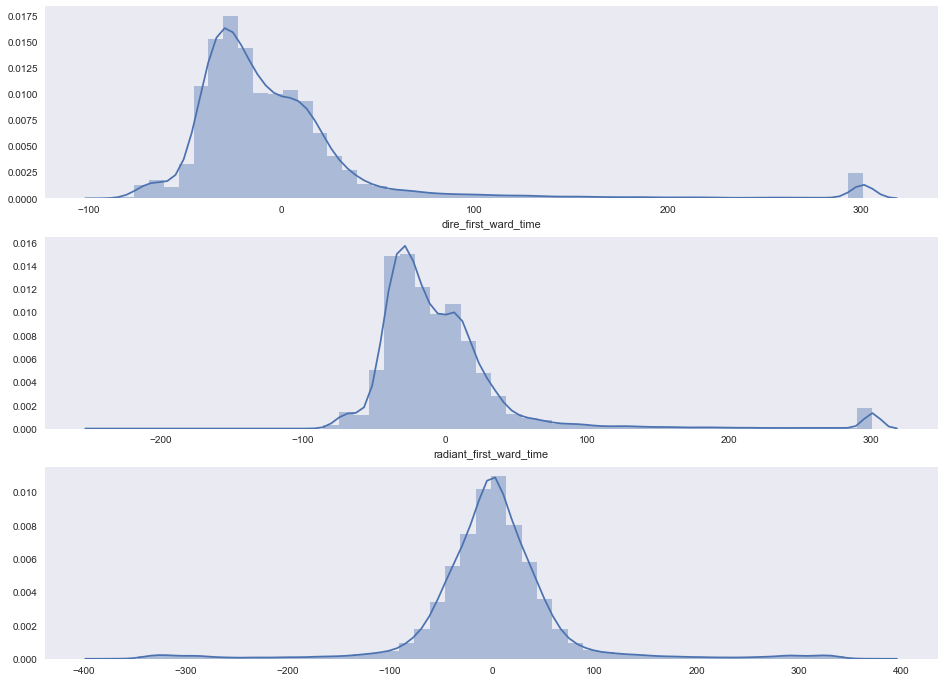

In [164]:
fig = plt.figure()
ax1 = plt.subplot2grid((3, 1), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 1), (1, 0), colspan=2)
ax3 = plt.subplot2grid((3, 1), (2, 0), colspan=2)
sns.distplot(df['dire_first_ward_time'], ax=ax1)
sns.distplot(df['radiant_first_ward_time'], ax=ax2)
sns.distplot(df['dire_first_ward_time'] - df['radiant_first_ward_time'], ax=ax3)

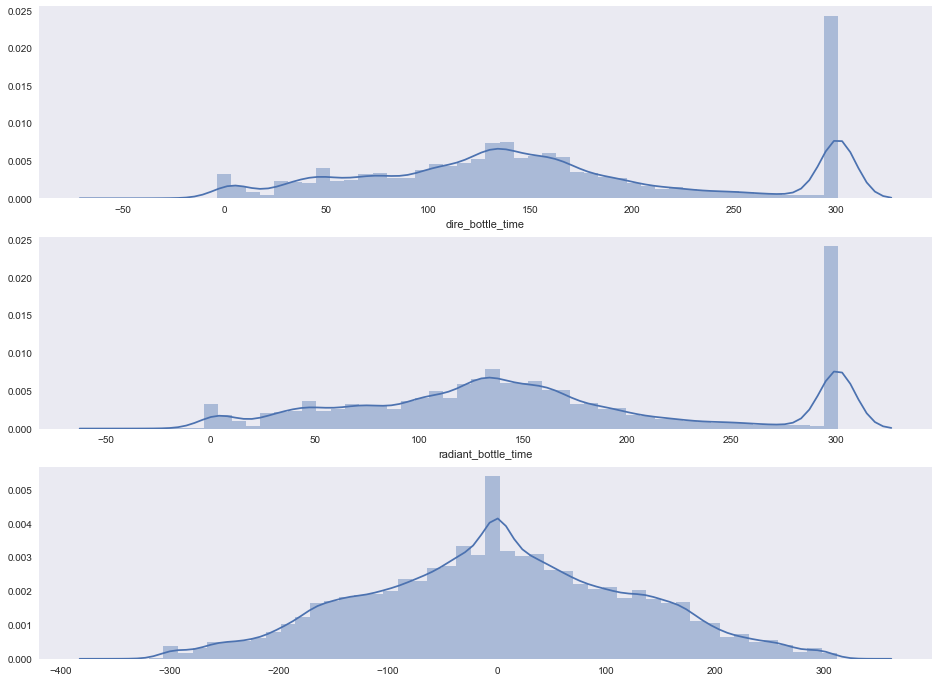

In [165]:
fig = plt.figure()
ax1 = plt.subplot2grid((3, 1), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 1), (1, 0), colspan=2)
ax3 = plt.subplot2grid((3, 1), (2, 0), colspan=2)
sns.distplot(df['dire_bottle_time'], ax=ax1)
sns.distplot(df['radiant_bottle_time'], ax=ax2)
sns.distplot(df['dire_bottle_time'] - df['radiant_bottle_time'], ax=ax3)

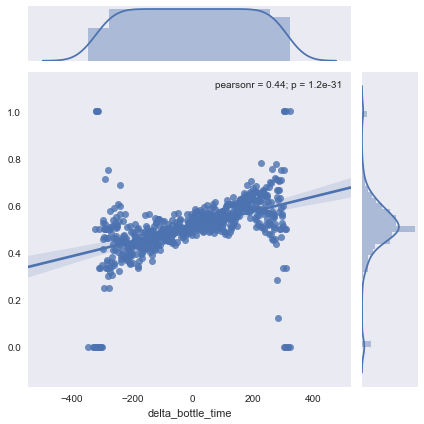

In [214]:
# Весьма логично, что чем больше разница времени покупки важного артефакта, тем больше шансов победить 

df['delta_bottle_time'] = df['dire_bottle_time'] - df['radiant_bottle_time']
h = df.groupby(['delta_bottle_time'])['radiant_win'].sum() / df.groupby(['delta_bottle_time'])['radiant_win'].count()
sns.jointplot(h.index, h.values, kind="reg")

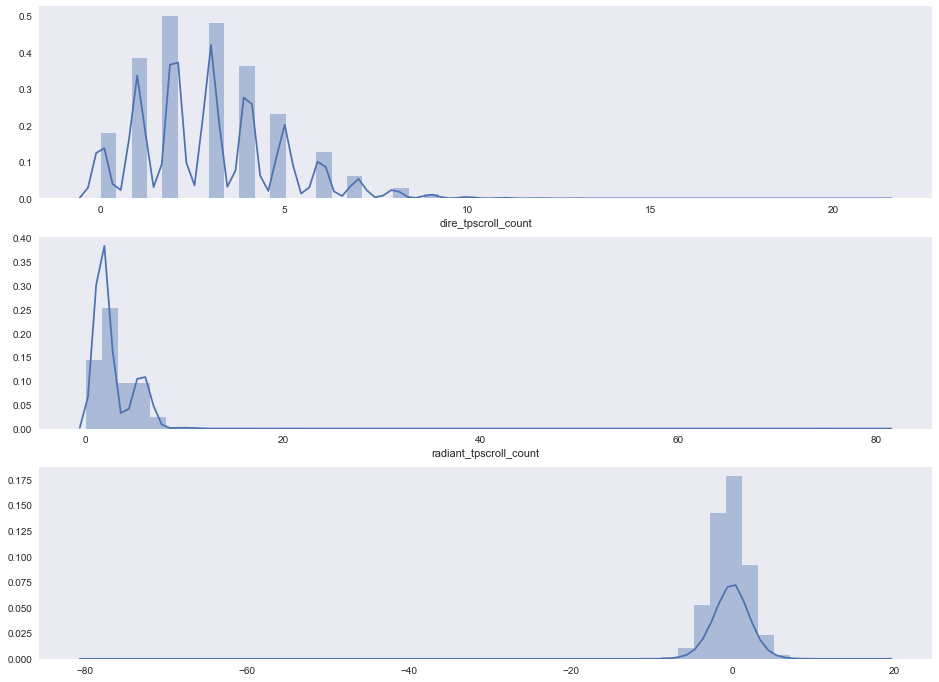

In [166]:
fig = plt.figure()
ax1 = plt.subplot2grid((3, 1), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 1), (1, 0), colspan=2)
ax3 = plt.subplot2grid((3, 1), (2, 0), colspan=2)
sns.distplot(df['dire_tpscroll_count'], ax=ax1)
sns.distplot(df['radiant_tpscroll_count'], ax=ax2)
sns.distplot(df['dire_tpscroll_count'] - df['radiant_tpscroll_count'], ax=ax3)

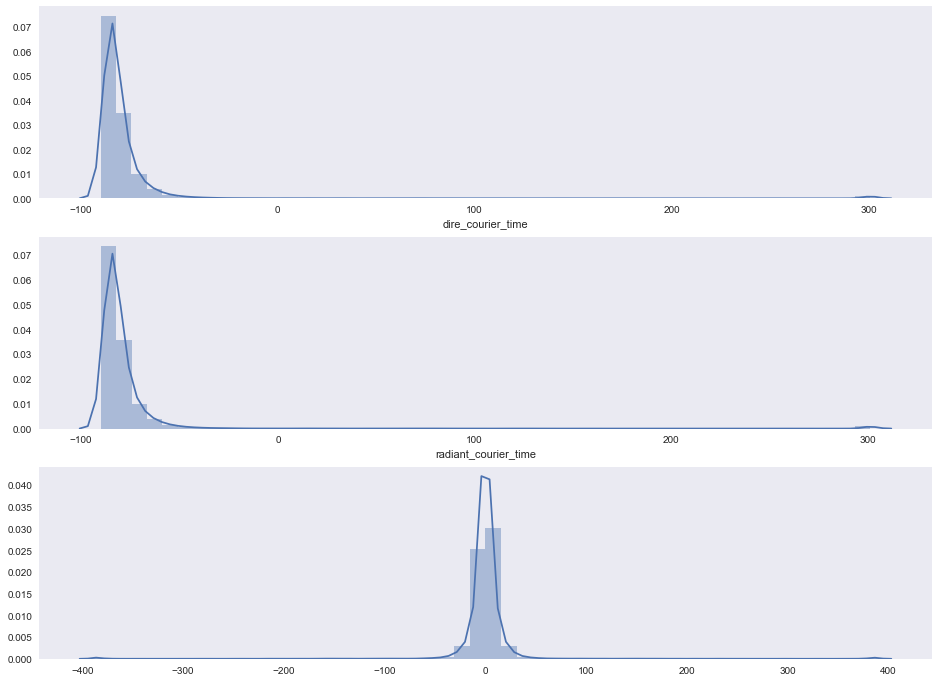

In [167]:
fig = plt.figure()
ax1 = plt.subplot2grid((3, 1), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 1), (1, 0), colspan=2)
ax3 = plt.subplot2grid((3, 1), (2, 0), colspan=2)
sns.distplot(df['dire_courier_time'], ax=ax1)
sns.distplot(df['radiant_courier_time'], ax=ax2)
sns.distplot(df['dire_courier_time'] - df['radiant_courier_time'], ax=ax3)

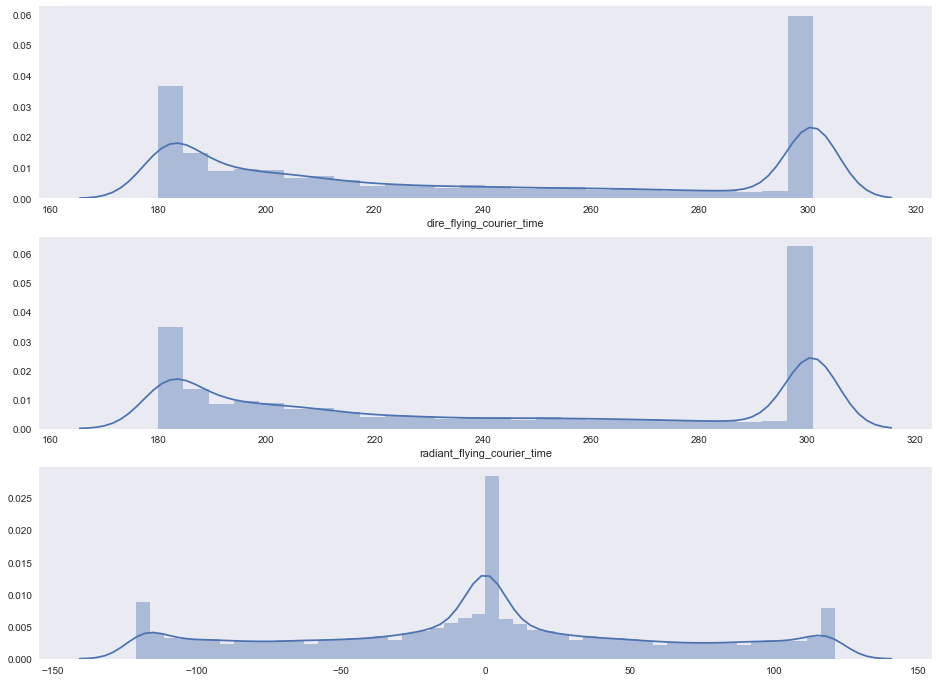

In [168]:
fig = plt.figure()
ax1 = plt.subplot2grid((3, 1), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 1), (1, 0), colspan=2)
ax3 = plt.subplot2grid((3, 1), (2, 0), colspan=2)
sns.distplot(df['dire_flying_courier_time'], ax=ax1)
sns.distplot(df['radiant_flying_courier_time'], ax=ax2)
sns.distplot(df['dire_flying_courier_time'] - df['radiant_flying_courier_time'], ax=ax3)

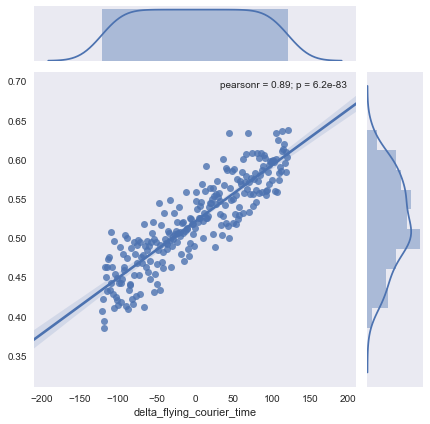

In [218]:
# Очень сильный признак - наличие ботинок

df['delta_flying_courier_time'] = df['dire_flying_courier_time'] - df['radiant_flying_courier_time']
h = df.groupby(['delta_flying_courier_time'])['radiant_win'].sum() / df.groupby(['delta_flying_courier_time'])['radiant_win'].count()
sns.jointplot(h.index, h.values, kind="reg")

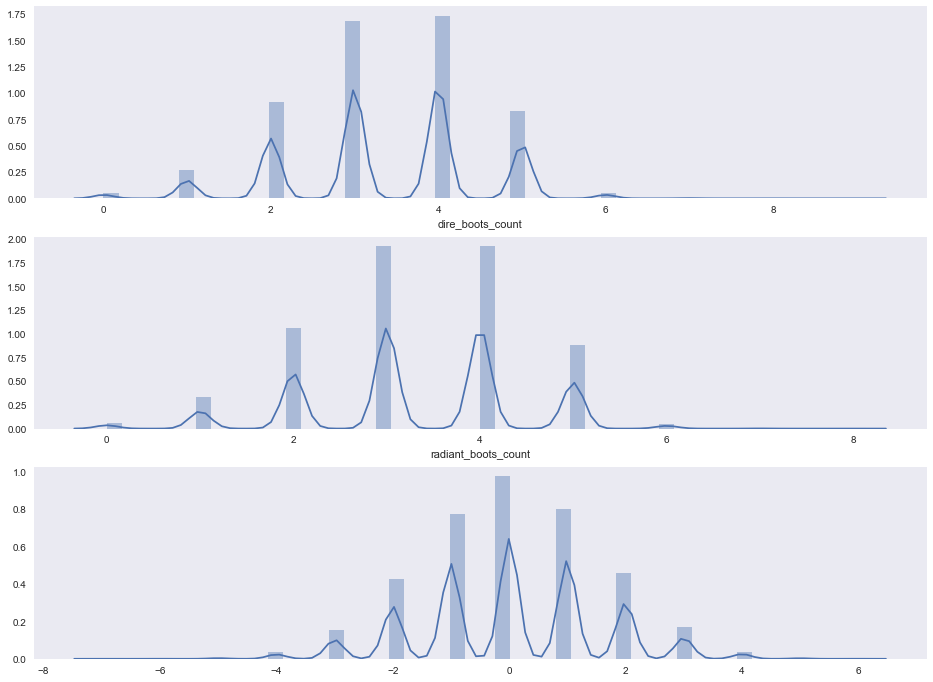

In [169]:
fig = plt.figure()
ax1 = plt.subplot2grid((3, 1), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 1), (1, 0), colspan=2)
ax3 = plt.subplot2grid((3, 1), (2, 0), colspan=2)
sns.distplot(df['dire_boots_count'], ax=ax1)
sns.distplot(df['radiant_boots_count'], ax=ax2)
sns.distplot(df['dire_boots_count'] - df['radiant_boots_count'], ax=ax3)

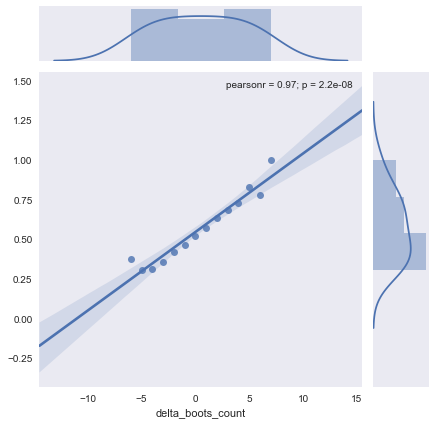

In [217]:
# Очень сильный признак - наличие ботинок

df['delta_boots_count'] = df['radiant_boots_count'] - df['dire_boots_count']
h = df.groupby(['delta_boots_count'])['radiant_win'].sum() / df.groupby(['delta_boots_count'])['radiant_win'].count()
sns.jointplot(h.index, h.values, kind="reg")

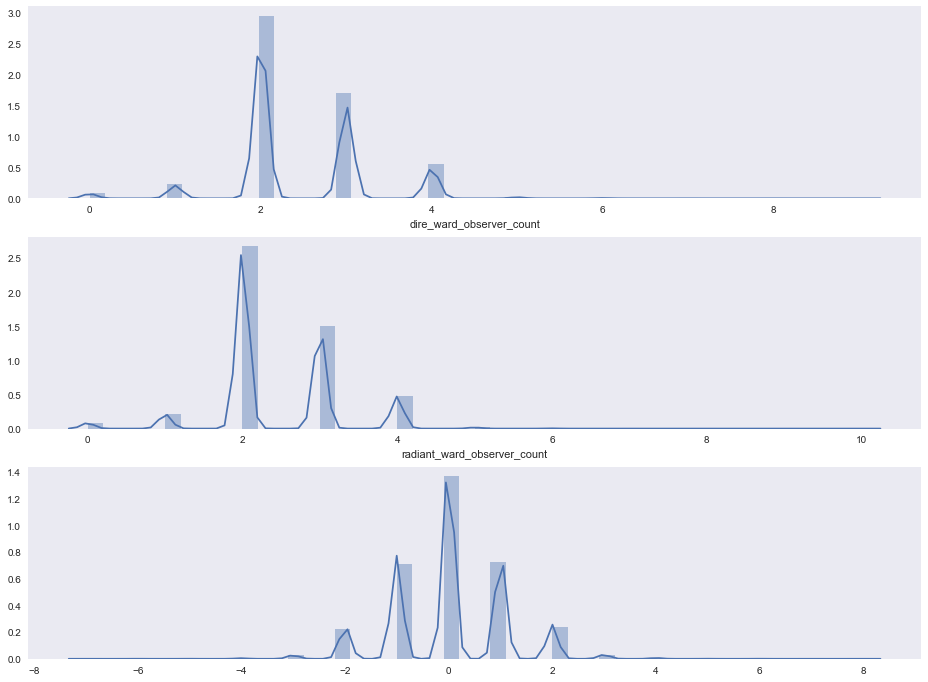

In [171]:
fig = plt.figure()
ax1 = plt.subplot2grid((3, 1), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 1), (1, 0), colspan=2)
ax3 = plt.subplot2grid((3, 1), (2, 0), colspan=2)
sns.distplot(df['dire_ward_observer_count'], ax=ax1)
sns.distplot(df['radiant_ward_observer_count'], ax=ax2)
sns.distplot(df['dire_ward_observer_count'] - df['radiant_ward_observer_count'], ax=ax3)

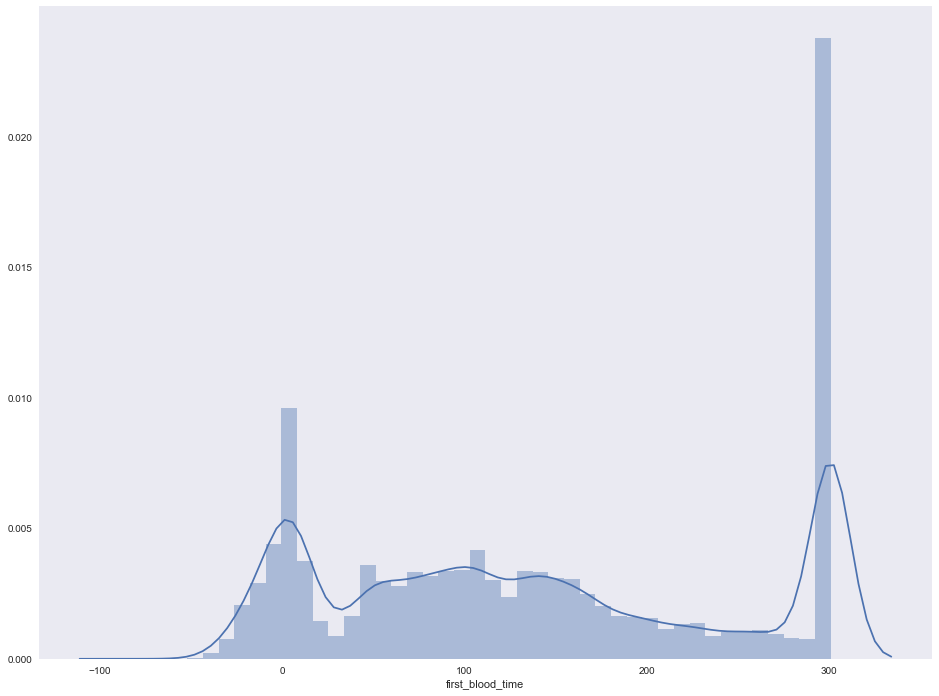

In [157]:
sns.distplot(df['first_blood_time'])

In [223]:
# какая команда сделал first blood тоже влияет
df.groupby(['first_blood_team'])['radiant_win'].sum() / df.groupby(['first_blood_team'])['radiant_win'].count()

first_blood_team
-1.0    0.527029
 0.0    0.594901
 1.0    0.444379
Name: radiant_win, dtype: float64

In [10]:
"""Метод для подготовки данных. 
Убирает все ненужные признаки, оставляет только полезные и проводит аггрегацию некоторых.
Заметим, что у нас теперь нет информации о героях совсем!
"""
def prepareData(X):
    X_ = pd.DataFrame(index=X.index)
    
    #X_['first_blood_team'] = X['first_blood_team']
    
    # Для этих признаков лучше больше, поэтому разность в прямом направлении
    dire_gold = X['d5_gold'] + X['d4_gold'] + X['d3_gold'] + X['d2_gold'] + X['d1_gold']
    radiant_gold = X['r5_gold'] + X['r4_gold'] + X['r3_gold'] + X['r2_gold'] + X['r1_gold']
    X_['gold_delta'] = radiant_gold - dire_gold # дельта золота на команду
    
    dire_lh = X['d5_lh'] + X['d4_lh'] + X['d3_lh']+ X['d2_lh'] +X['d1_lh']
    radiant_lh = X['r5_lh'] + X['r4_lh'] + X['r3_lh']+ X['r2_lh'] +X['r1_lh']
    X_['lh_delta'] = radiant_lh - dire_lh # дельта числа убитых юнитов
    
    dire_items = X['d5_items'] + X['d4_items'] + X['d3_items'] + X['d2_items'] + X['d1_items'] 
    radiant_items = X['r5_items'] + X['r4_items'] + X['r3_items'] + X['r2_items'] + X['r1_items']
    X_['items_delta'] = radiant_items - dire_items # дельта числа купленных предметов
    
    dire_boots_count = X['dire_boots_count']
    radiant_boots_count = X['radiant_boots_count']
    X_['boots_count_delta'] = radiant_boots_count - dire_boots_count # дельта числа ботинок на команду
    
    dire_xp = X['d5_xp'] + X['d4_xp'] + X['d3_xp'] + X['d2_xp'] + X['d1_xp']
    radiant_xp = X['r5_xp'] + X['r4_xp'] + X['r3_xp'] + X['r2_xp'] + X['r1_xp']
    X_['xp_delta'] = radiant_xp - dire_xp # дельта опыта на команду. Нам не нужны поэтому уровни, так как они зависимы друг от друга, но не совсем линейно
    
    dire_kills = X['d5_kills'] + X['d4_kills'] + X['d3_kills'] + X['d2_kills'] + X['d1_kills']
    radiant_kills = X['r5_kills'] + X['r4_kills'] + X['r3_kills'] + X['r2_kills'] + X['r1_kills']
    X_['kills_delta'] = radiant_kills - dire_kills # дельта килов героев на команду
    
    X_['tpscroll_count_delta'] = X['radiant_tpscroll_count'] - X['dire_tpscroll_count'] # дельта числа свитков телепортации
    X_['ward_observer_count_delta'] = X['radiant_ward_observer_count'] - X['dire_ward_observer_count']
    X_['ward_sentry_count_delta'] = X['radiant_ward_sentry_count'] - X['dire_ward_sentry_count']
    
    # Для времени лучше меньше чем больше поэтому разность в другую сторону
    X_['bottle_time_delta'] = X['dire_bottle_time'] - X['radiant_bottle_time']
    X_['flying_courier_time_delta'] = X['dire_flying_courier_time'] - X['radiant_flying_courier_time']
    X_['courier_time_delta'] = X['dire_courier_time'] - X['radiant_courier_time']
    X_['first_ward_time_delta'] = X['dire_first_ward_time'] - X['radiant_first_ward_time']
    
    return X_

In [11]:
def drawJointPlots(df):
    X = prepareData(df)
    y = df['radiant_win']
    d = pd.concat([X, y], axis=1)
    for column in X.columns:
        h = d.groupby([column])['radiant_win'].sum() / d.groupby([column])['radiant_win'].count()
        sns.jointplot(h.index, h.values, kind="reg")

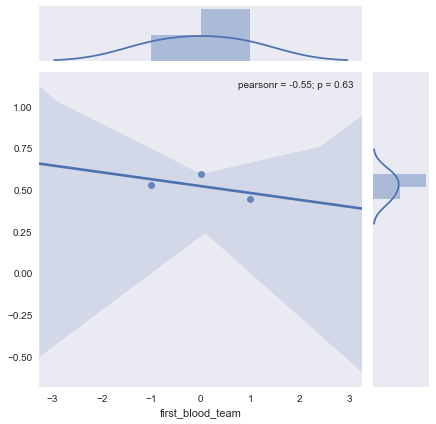

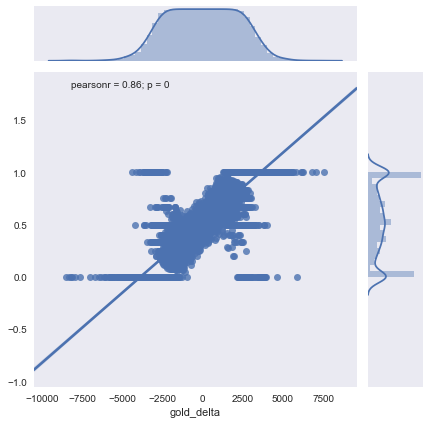

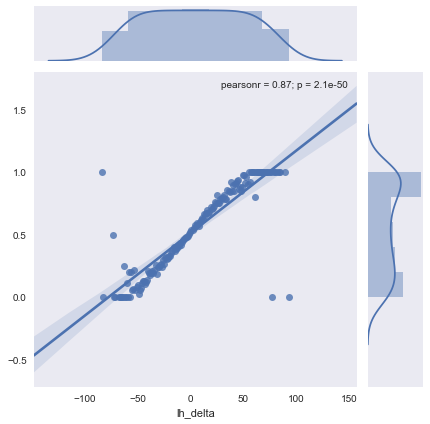

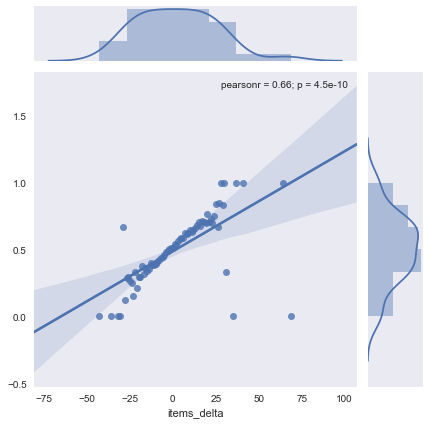

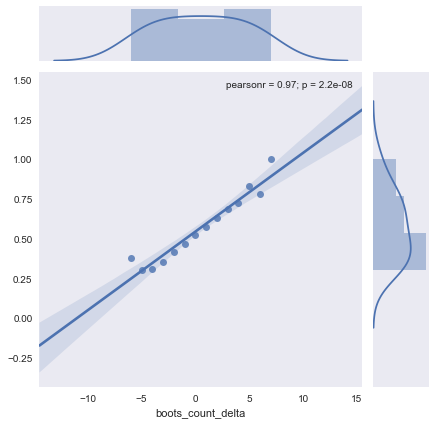

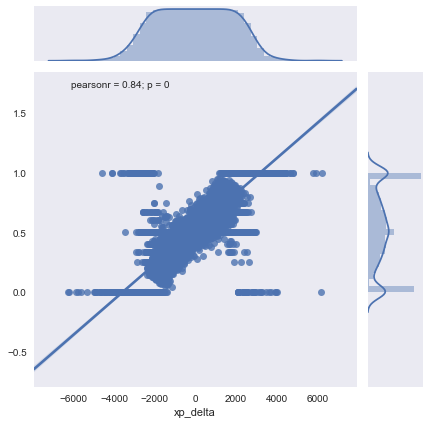

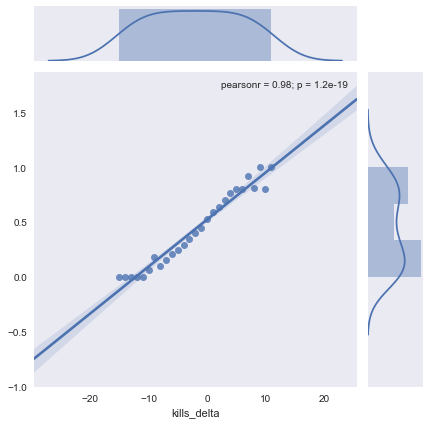

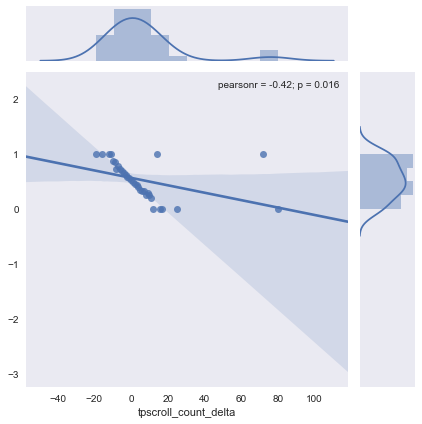

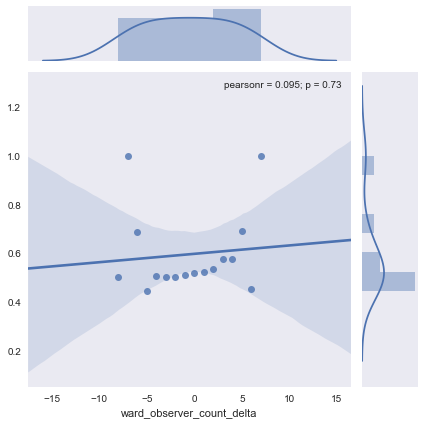

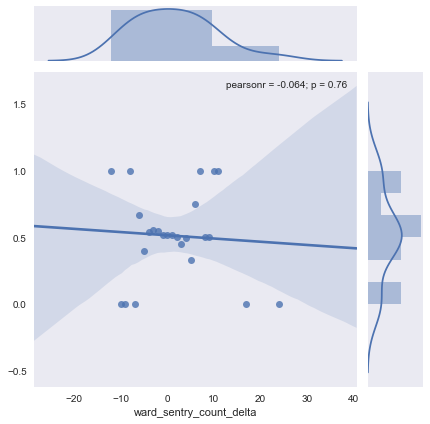

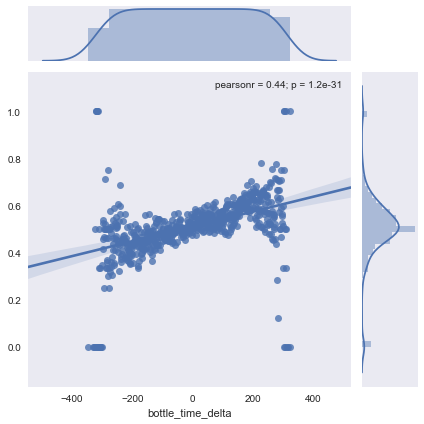

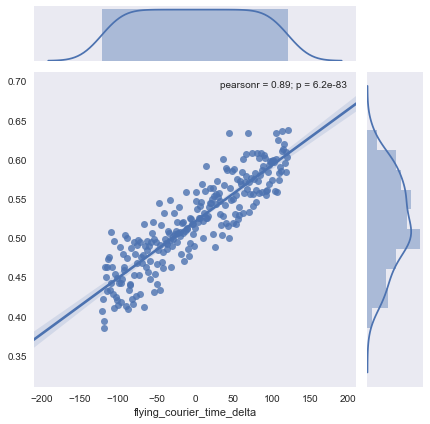

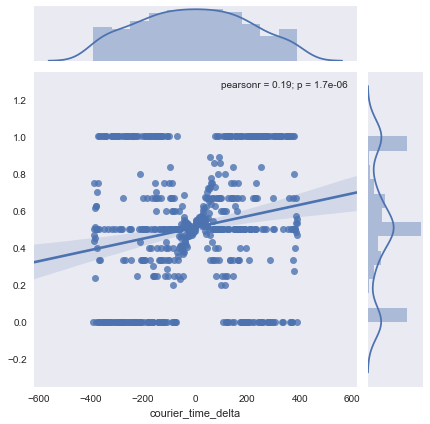

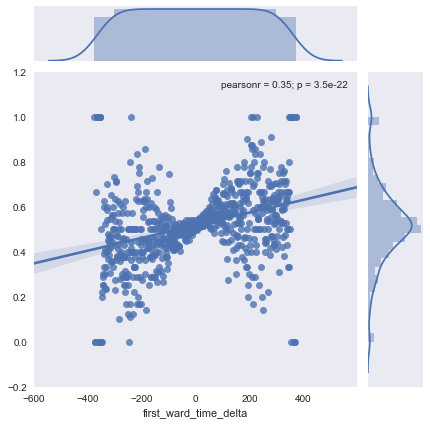

In [241]:
drawJointPlots(df)

Теперь запустим наш набор классификаторов по этим сгенерированным признакам

In [25]:
classifiers = [
    DummyClassifier(random_state=42), 
    Lasso(random_state=42), 
    RidgeClassifier(random_state=42),
    SGDClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(n_estimators=50, random_state=42),
    RandomForestClassifier(n_estimators=50, random_state=42),
    LogisticRegression(),
    XGBClassifier()
]


X = prepareData(df)
y = df['radiant_win']
results = [examine(clf, X, y) for clf in classifiers]
results = sorted(results, key=lambda el: el[2])

for r in results:
    print_report(r)

DummyClassifier. roc_auc 0.49717 +-0.00387. Time to fit: 0:00:00.789380
SGDClassifier. roc_auc 0.53804 +-0.39659. Time to fit: 0:00:01.278752
RandomForestClassifier. roc_auc 0.70004 +-0.00560. Time to fit: 0:00:32.308052
Lasso. roc_auc 0.71203 +-0.00399. Time to fit: 0:00:00.865265
AdaBoostClassifier. roc_auc 0.71310 +-0.00389. Time to fit: 0:00:13.279042
GradientBoostingClassifier. roc_auc 0.71632 +-0.00312. Time to fit: 0:00:26.567311
XGBClassifier. roc_auc 0.71646 +-0.00282. Time to fit: 0:00:11.247118
LogisticRegression. roc_auc 0.71716 +-0.00258. Time to fit: 0:00:03.418134
RidgeClassifier. roc_auc 0.71717 +-0.00247. Time to fit: 0:00:00.979929


Заметим, что линейные модели до сих пор решают проблему лучше всего. Потому что мы выше создали линейные комбинации прошлых признаков. НО зато ансамблевые модели стали вычисляться **намного быстрее** и качество стало таким же как у линейных моделей.

# Синергия героев

![](images/heroes.jpg)

До сих пор мы с вами рассматривали только числовые характеристики - время, количество чего-то. Но у нас есть очень много информации о героях. Учитывая специфику игры, можно предположить, что в долгосрочной перспективе решающим фактором может стать особая способность героев, их комбинация и так далее. Поэтому стоит каким-то образом внести в признаковое пространство героев.

Для этого можно составить мешок слов - мешок героев. Т.е. мы добавим матрицу, где в столбцах - герои, а в ячейках - 1 или -1 - т.е. за кого играет герой в данном матче. Или в ячейке может быть то сколько золота, опыта, предметов, киллов у данного персонажа. Это всё стоит проверить на выборке.

In [12]:
def wordsBag(X, N=113):
    # N — количество различных героев в выборке
    X_pick = np.zeros((X.shape[0], N))

    for i, match_id in enumerate(X.index):
        for p in range(5):
            X_pick[i, X.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
            X_pick[i, X.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

    return X_pick

In [289]:
bag = wordsBag(df, 113)
print_report(examine(LogisticRegression(random_state=42), pd.DataFrame(bag, index=df.index), y))

LogisticRegression. roc_auc 0.57697 +-0.00685. Time to fit: 0:00:02.288503


Только на одном мешке слов, мы получили качество предсказания 0.6!! Это лучше, чем тупой предсказатель и на уровне с первыми решениями в лоб. Кажется это действительно улучшит качество!

In [14]:
def wordsBag_Exp(X, N=113):
    # N — количество различных героев в выборке
    X_pick = np.zeros((X.shape[0], N))

    for i, match_id in enumerate(X.index):
        for p in range(5):
            X_pick[i, X.ix[match_id, 'r%d_hero' % (p+1)]-1] = X.ix[match_id, 'r%d_gold' % (p+1)] * X.ix[match_id, 'r%d_xp' % (p+1)]
            X_pick[i, X.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1 * X.ix[match_id, 'd%d_gold' % (p+1)] * X.ix[match_id, 'd%d_xp' % (p+1)]

    return X_pick

In [15]:
bag_exp = wordsBag_Exp(df, 113)

In [ ]:
print_report(examine(LogisticRegression(), pd.DataFrame(bag_exp, index=df.index), y))

In [45]:
print_report(examine(GradientBoostingClassifier(n_estimators=50, random_state=42), pd.DataFrame(bag_exp, index=df.index), y))

GradientBoostingClassifier. roc_auc 0.64970 +-0.00533. Time to fit: 0:02:12.656321


In [50]:
print_report(examine(XGBClassifier(seed=42), pd.DataFrame(bag_exp, index=df.index), y))

XGBClassifier. roc_auc 0.66959 +-0.00625. Time to fit: 0:01:05.651834


ROC_AUC 0.74 в линейной модели по мешку взвешенных героев??? Oh RLY?

![](images/omg_omg_cat.jpg)

In [16]:
def wordsBag_KillsDeath(X, N=113):
    # N — количество различных героев в выборке
    X_pick = np.zeros((X.shape[0], N))

    for i, match_id in enumerate(X.index):
        for p in range(5):
            X_pick[i, X.ix[match_id, 'r%d_hero' % (p+1)]-1] = (X.ix[match_id, 'r%d_kills' % (p+1)] + 1) / (X.ix[match_id, 'r%d_deaths' % (p+1)] + 1)
            X_pick[i, X.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1 * (X.ix[match_id, 'd%d_kills' % (p+1)] + 1) / (X.ix[match_id, 'd%d_deaths' % (p+1)] + 1)

    return X_pick

In [291]:
bag_kd = wordsBag_KillsDeath(df, 113)
print_report(examine(LogisticRegression(), pd.DataFrame(bag_kd, index=df.index), y))

LogisticRegression. roc_auc 0.66917 +-0.00506. Time to fit: 0:00:02.967890


In [17]:
def wordsBag_Lh(X, N=113):
    # N — количество различных героев в выборке
    X_pick = np.zeros((X.shape[0], N))

    for i, match_id in enumerate(X.index):
        for p in range(5):
            X_pick[i, X.ix[match_id, 'r%d_hero' % (p+1)]-1] = (X.ix[match_id, 'r%d_lh' % (p+1)] + 1)
            X_pick[i, X.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1 * (X.ix[match_id, 'd%d_lh' % (p+1)] + 1)

    return X_pick

In [39]:
bag_lh = wordsBag_Lh(df, 113)
print_report(examine(LogisticRegression(), pd.DataFrame(bag_lh, index=df.index), y))

LogisticRegression. roc_auc 0.71066 +-0.00656. Time to fit: 0:00:03.078102


In [18]:
def wordsBag_Items(X, N=113):
    # N — количество различных героев в выборке
    X_pick = np.zeros((X.shape[0], N))

    for i, match_id in enumerate(X.index):
        for p in range(5):
            X_pick[i, X.ix[match_id, 'r%d_hero' % (p+1)]-1] = (X.ix[match_id, 'r%d_items' % (p+1)] + 1)
            X_pick[i, X.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1 * (X.ix[match_id, 'd%d_items' % (p+1)] + 1)

    return X_pick

In [293]:
bag_items = wordsBag_Items(df, 113)
print_report(examine(LogisticRegression(), pd.DataFrame(bag_items, index=df.index), y))

LogisticRegression. roc_auc 0.64317 +-0.00538. Time to fit: 0:00:03.093035


In [295]:
bag_all = np.concatenate([bag_exp, bag_items, bag_kd, bag_lh], axis = 1)
print_report(examine(LogisticRegression(), pd.DataFrame(bag_all, index=df.index), y))
# ну это было тупо, так как логистическая регрессия просто выкинула другие коэффициенты

LogisticRegression. roc_auc 0.74126 +-0.00571. Time to fit: 0:00:06.848674


# Настало время ансамблей!!

Генерируем признаки, предсказываем победителя на разных моделях, потом берем предсказания и на основе них опять делаем предсказания!!
Для этого создадим свой первый Трансформер признаков и Пайплайн!
![](images/deepers.png)

In [26]:
# Просто так сделать сложную модель нельзя. Придётся писать свой класс.

class DataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, func):
        self.func = func
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        return self.func(X)

In [33]:
# items_clf = Pipeline([('items_bag', BagTransformer(wordsBag_Items)), ('clf', LogisticRegression(random_state=42))])
exp_clf = Pipeline([('exp_bag', DataTransformer(wordsBag_Exp)), ('clf', LogisticRegression(random_state=42))])
kills_clf = Pipeline([('kills_bag', DataTransformer(wordsBag_KillsDeath)), ('clf', LogisticRegression(random_state=42))])
lh_clf = Pipeline([('lh_bag', DataTransformer(wordsBag_Lh)), ('clf', LogisticRegression(random_state=42))])
clf_heroes = VotingClassifier([
#     ('items_clf', items_clf), 
    ('exp_clf', exp_clf), 
    ('kills_clf', kills_clf), 
    ('lh_clf', lh_clf)
], voting='soft')

In [46]:
%time print_report(examine(clf_heroes, get_X(df), get_Y(df)))

VotingClassifier. roc_auc 0.74452 +-0.00597. Time to fit: 0:07:18.879359
CPU times: user 1.2 s, sys: 268 ms, total: 1.47 s
Wall time: 7min 18s


Самая лучшая модель отдельно давала 0.74126, ансамбль же дал 0.74452. Прирост 0.0033 можно считать значимым!

In [24]:
def poly_experiment(bag):
    pf = PolynomialFeatures()
    bag_poly = sparse.csr_matrix(pf.fit_transform(bag))
    print_report(examine(LogisticRegression(), bag_poly, y))

# Слияние моделей

Теперь объединим модели основанные на характеристиках героев и характеристиках команды в целом.

Напомню, Лучшее предсказание для команды было 0.71718, для героев 0.74452. Есть надежда что комбинация даст 0.75

In [47]:
# Строим вундервафлю для предсказания по командам

clf_lr = Pipeline([
    ('prepare_data', DataTransformer(prepareData)), 
    ('clf', LogisticRegression(random_state=42))
])
clf_xgb = Pipeline([
    ('prepare_data', DataTransformer(prepareData)), 
    ('clf', XGBClassifier(n_estimators=100, max_depth=5,seed=42))
])

clf_team = VotingClassifier([('xgb', clf_xgb), ('lr', clf_lr)], voting='soft')
print_report(examine(clf_team, get_X(df), get_Y(df)))

VotingClassifier. roc_auc 0.71701 +-0.00281. Time to fit: 0:00:21.290904


In [37]:
clf = VotingClassifier([('heroes', clf_heroes), ('team', clf_team)], voting='soft')
print_report(examine(clf, get_X(df), get_Y(df)))

VotingClassifier. roc_auc 0.74131 +-0.00380. Time to fit: 0:06:34.645958


Так, стоп, погодите, у нас ничего не улучшилось. Это как так вообще???

![](images/wtf.png)

In [38]:
exp_clf = Pipeline([('exp_bag', DataTransformer(wordsBag_Exp)), ('clf', LogisticRegression(random_state=42))])
clf_lr = Pipeline([('prepare_data', DataTransformer(prepareData)), ('clf', LogisticRegression(random_state=42))])
clf = VotingClassifier([('heroes', exp_clf), ('team', clf_lr)], voting='soft')
print_report(examine(clf, get_X(df), get_Y(df)))

VotingClassifier. roc_auc 0.74055 +-0.00375. Time to fit: 0:02:30.441292


In [40]:
X = np.concatenate([DataTransformer(wordsBag_Exp).transform(get_X(df)), DataTransformer(prepareData).transform(get_X(df))], axis=1)
y = get_Y(df)

In [46]:
clf = LogisticRegression(random_state=42, C=0.112)
print_report(examine(clf, X, y))

LogisticRegression. roc_auc 0.74335 +-0.00542. Time to fit: 0:01:09.665944


В общем машинное обучение это еще так странная штука.

![](images/daria.jpg)